建立一个神经网络，它有一个隐藏层

- 构建具有单隐藏层的2类分类神经网络。

- 使用具有非线性激活功能激活函数，例如tanh。

- 计算交叉熵损失（损失函数）。

- 实现向前和向后传播。


准备一些软件包
- numpy：是用Python进行科学计算的基本软件包。
- sklearn：为数据挖掘和数据分析提供的简单高效的工具。
- matplotlib ：是一个用于在Python中绘制图表的库。
- testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。
- planar_utils ：提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。

In [1]:
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import matplotlib.pyplot as plt

# 设置中文字体（Windows 用户推荐 SimHei）
matplotlib.rcParams['font.family'] = 'SimHei'

# 设置负号正常显示
matplotlib.rcParams['axes.unicode_minus'] = False

提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。
- planar_utils ：提供了在这个任务中使用的各种有用的功能，参见下载的资料或者在底部查看它的代码。

In [2]:
# 绘制决策边界函数，定义一个函数，用来画出模型对二维数据的分类边界
def plot_decision_boundary(model, X, y):
    # 取出输入特征 X 的横轴（第0行）和纵轴（第1行）值的最小最大值，+1/-1 是为了给图像留点边缘空白。
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) # 生成网格点 假设边界是 -5 到 5，步长 0.01，它会生成一个网格（像素级别的坐标）

    Z = model(np.c_[xx.ravel(), yy.ravel()]) # 将网格坐标点展开为形如 (num_points, 2) 的格式，然后送入模型中预测，得出每个点的分类。目的是为了绘制决策边界
    Z = Z.reshape(xx.shape) # 将预测结果重新 reshape 成和 xx 相同的形状，以便绘图使用。
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) # 绘制等高线图，等高线表示决策边界，颜色越深表示分类结果越接近。cmap=plt.cm.Spectral 指定了颜色映射方案，不同的分类会用不同的颜色表示。

    # 设置坐标轴，并绘制原始数据的散点图。注意 np.squeeze(y) 是为了把 (1, m) 变成 (m,)。
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)

def sigmoid(z):
    """
    sigmoid 函数
    """
    z = np.clip(z, -500, 500)
    s = 1 / (1 + np.exp(-z))
    return s

# 加载花型数据集的函数
def load_planar_dataset():
    np.random.seed(1) # 设置随机种子，保证每次运行生成的结果相同。
    m = 400 # 样本数为 400
    N = int(m / 2) # 每个类别有200个样本，为0的有200个，为1的有200个
    D = 2 # 数据维度为2
    X = np.zeros((m, D)) # 初始化 X 为全零矩阵，形状为 (m, D)，m 是样本数，D 是特征数
    Y = np.zeros((m, 1), dtype="uint8")
    a = 4 # 控制生成图形的半径范围

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2 # 生成角度，加一些高斯噪声
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2 # 生成半径，也加入噪声，使数据更逼近真实情况
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)] # 用极坐标公式转为笛卡尔坐标存入 X
        Y[ix] = j # 将这部分数据标记为 j 类（0 或 1）

    X = X.T # (2, m)
    Y = Y.T # (1, m)

    return X, Y

# 测试load_planar_dataset()
X, Y = load_planar_dataset()
# print(X)
# print(X.shape)
# print(Y)
# print(Y.shape)

# 加载额外数据集函数 load_extra_datasets
def load_extra_datasets():
    N = 200 # 样本数
    nosiy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3) # 生成两个圆圈嵌套的二分类数据集（factor 控制两个圈的半径比例）。
    nosiy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2) # 生成两个半月形的数据集，常用于二分类可视化。
    blods = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6) # 生成多个类（6 类）的随机数据集，常用于多分类可视化。
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2) # 生成完全无结构的二维点，表示随机分布的两个类。

    return nosiy_circles, nosiy_moons, blods, gaussian_quantiles, no_structure

输入参数：

- model: 是一个可以输入二维坐标并输出分类结果的模型函数（比如你训练好的逻辑回归或者神经网络模型）。

- X: 输入的二维数据，形状是 (2, m)，其中：

    - 第0行是 x 坐标

    - 第1行是 y 坐标

- y: 每个点的真实标签，形状是 (1, m)，0或1。

测试plot_decision_boundary函数

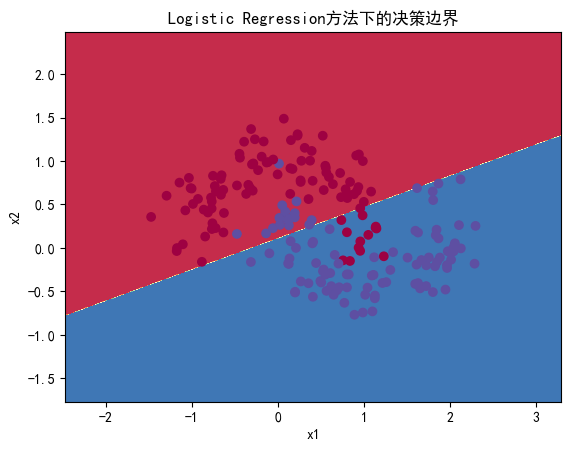

In [11]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression

# 生成玩具数据：两半月形状的分类问题
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
# print(X)
# print((X.shape))
# print(y)
# print((y.shape))

# 转置数据，使其符合 plot_decision_boundary 所要求的形状 (2, m)
X_transposed = X.T
y_transposed = y.reshape(1, -1)

# print(X_transposed.shape) # (2, 200)
# print(y_transposed.shape) # (1, 200)

# 拟合一个逻辑回归模型
clf = LogisticRegression()
clf.fit(X, y)

# 定义包装模型的函数，使其输入为 (n, 2)，输出为预测标签
def model_predict(X_input):
    return clf.predict(X_input)

plot_decision_boundary(model_predict, X_transposed, y_transposed)
plt.title("Logistic Regression方法下的决策边界")
plt.show()

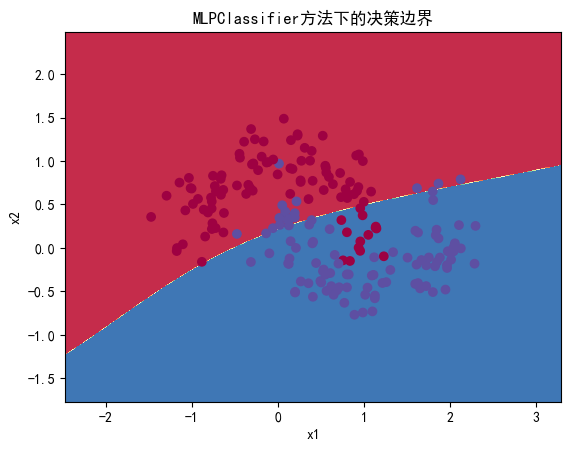

In [51]:
from sklearn.datasets import make_moons
from sklearn.neural_network import MLPClassifier

# 生成玩具数据：两半月形状的分类问题
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
# print(X)
# print((X.shape))
# print(y)
# print((y.shape))

# 转置数据，使其符合 plot_decision_boundary 所要求的形状 (2, m)
X_transposed = X.T
y_transposed = y.reshape(1, -1)

# print(X_transposed.shape) # (2, 200)
# print(y_transposed.shape) # (1, 200)

# 非线性模型
clf = MLPClassifier(hidden_layer_sizes=(5, 5), activation='tanh', max_iter=10000)
clf.fit(X, y.T.ravel())

# 定义包装模型的函数，使其输入为 (n, 2)，输出为预测标签
def model_predict(X_input):
    return clf.predict(X_input)

plot_decision_boundary(model_predict, X_transposed, y_transposed)
plt.title("MLPClassifier方法下的决策边界")
plt.show()

## 数据集

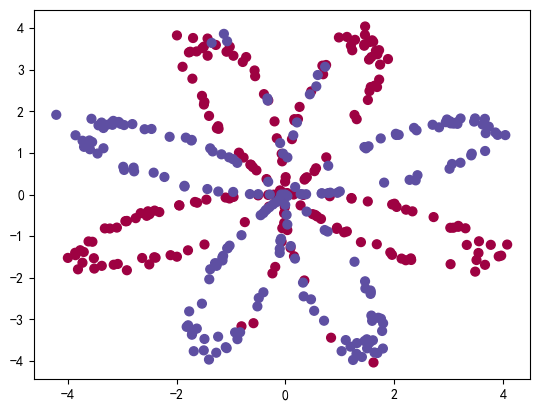

In [3]:
X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral) #绘制散点图

X：一个numpy的矩阵，包含了这些数据点的数值

Y：一个numpy的向量，对应着的是X的标签【0 | 1】（红色:0 ， 蓝色 :1）

查看数据

In [52]:
X_shape = X.shape
Y_shape = Y.shape
m = Y.shape[1]

print("X.shape = ", X_shape)
print("Y.shape = ", Y_shape)
print ("数据集里面的数据有：" + str(m) + " 个")

X.shape =  (2, 400)
Y.shape =  (1, 400)
数据集里面的数据有：400 个


逻辑回归的准确性： 47.00 % (正确标记的数据点所占的百分比)


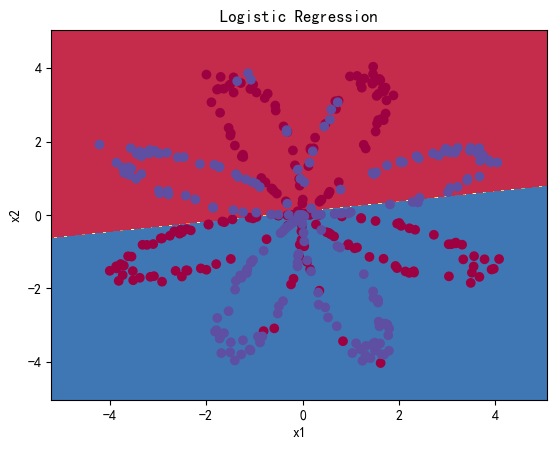

In [42]:
from sklearn.neural_network import MLPClassifier

clf = sklearn.linear_model.LogisticRegressionCV() # 线性
# clf = MLPClassifier(hidden_layer_sizes=(5, 5), activation='tanh', max_iter=10000) # 非线性
clf.fit(X.T, Y.T.ravel())

plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")
LR_predictions = clf.predict(X.T)
accuracy = (np.sum(Y * LR_predictions) + np.sum((1 - Y) * (1 - LR_predictions))) / float(Y.size) * 100
# print(np.sum(Y * LR_predictions))
# print(np.sum((1 - Y) * (1 - LR_predictions)))
# print(Y.size)
print("逻辑回归的准确性： %.2f %% (正确标记的数据点所占的百分比)" % accuracy)
plt.show()

- testCases：提供了一些测试示例来评估函数的正确性，参见下载的资料或者在底部查看它的代码。

每个函数都用来模拟某个阶段的输入和输出，以便你在实现具体算法时可以用这些数据来验证自己代码是否正确。

In [4]:
# -*- coding: UTF-8 -*-
# 函数1：测试用例，生成一组输入和标签矩阵，供神经网络测试输入输出形状
def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(5, 3) # 输入数据，5 个特征，3 个样本
    Y_assess = np.random.randn(2, 3) # 标签数据，2 类，3 个样本

    return X_assess, Y_assess
# 测试
# X_assess, Y_assess = layer_sizes_test_case()
# print("X_assess.shape = " + str(X_assess.shape))
# print("Y_assess.shape = " + str(Y_assess.shape))
# print(X_assess)
# print(Y_assess)

# 函数2：提供一个固定的网络层大小设置（输入层 2，隐藏层 4，输出层 1）
def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y

# 函数3：前向传播测试用例，提供输入 X 和初始化好的参数
def forward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3) # 输入数据，2 个特征，3 个样本

    parameters = {
        'W1': np.array([[-0.00416758, -0.00056267],
                       [-0.02136196,  0.01640271],
                       [-0.01793436, -0.00841747],
                       [ 0.00502881, -0.01245288]]),  # W1 权重矩阵 4x2
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),  # W2 权重矩阵 1x4
        'b1': np.array([[0.], [0.], [0.], [0.]]),  # b1 偏置向量 4x1
        'b2': np.array([[0.]])  # b2 偏置标量 1x1
    }

    return X_assess, parameters

# 函数4：用于测试成本函数的计算
def compute_cost_test_case():
    np.random.seed(1)
    Y_assess = np.random.randn(1, 3)

    parameters = {
        'W1': np.array([[-0.00416758, -0.00056267],
                       [-0.02136196,  0.01640271],
                       [-0.01793436, -0.00841747],
                       [ 0.00502881, -0.01245288]]),
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
        'b1': np.array([[0.], [0.], [0.], [0.]]),
        'b2': np.array([[0.]])
    }
    a2 = np.array([[0.5002307, 0.49985831, 0.50023963]])  # 模拟的输出层激活值， 成本函数计算仅需要输出层激活值，之前层的激活值可以忽略

    return Y_assess, parameters, a2

# 函数5：用于测试反向传播的梯度计算
def backward_propagation_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    parameters = {
        'W1': np.array([[-0.00416758, -0.00056267],
                       [-0.02136196,  0.01640271],
                       [-0.01793436, -0.00841747],
                       [ 0.00502881, -0.01245288]]),
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]),
        'b1': np.array([[0.], [0.], [0.], [0.]]),
        'b2': np.array([[0.]])
    }
    cache = {
        'A1': np.array([[-0.00616578,  0.0020626,  0.00349619],
                         [-0.05225116,  0.02725659, -0.02646251],
                         [-0.02009721,  0.0036869,  0.02883756],
                         [ 0.02152675, -0.01385234,  0.02599885]]),
        'A2': np.array([[0.5002307, 0.49985831, 0.50023963]]),
        'Z1': np.array([[-0.00616586, 0.0020626, 0.0034962],
                         [-0.05229879, 0.02726335, -0.02646869],
                         [-0.02009991, 0.00368692, 0.02884556],
                         [0.02153007, -0.01385322, 0.02600471]]),
        'Z2': np.array([[0.00092281, -0.00056678, 0.00095853]])
    }
    return parameters, cache, X_assess, Y_assess

# 函数6：用于测试参数更新是否正确
def update_parameters_test_case():
    parameters = {
        'W1': np.array([[-0.00615039,  0.0169021],
                       [-0.02311792,  0.03137121],
                       [-0.0169217,  -0.01752545],
                       [ 0.00935436, -0.05018221]]),
        'W2': np.array([[-0.0104319, -0.04019007, 0.01607211, 0.04440255]]),
        'b1': np.array([[-8.97523455e-07], [8.15562092e-06], [6.04810633e-07], [-2.54560700e-06]]),
        'b2': np.array([[9.14954378e-05]])
    }
    grads = {
        'dW1': np.array([[0.00023322, -0.00205423], [0.00082222, -0.00700776],
                         [-0.00031831, 0.0028636], [-0.00092857, 0.00809933]]),
        'dW2': np.array([[-1.75740039e-05, 3.70231337e-03, -1.25683095e-03, -2.55715317e-03]]),
        'db1': np.array([[1.05570087e-07], [-3.81814487e-06], [-1.90155145e-07], [5.46467802e-07]]),
        'db2': np.array([[-1.08923140e-05]])
    }
    return parameters, grads

# 函数7：用于测试完整神经网络模型训练函数的输入输出结构
def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    Y_assess = np.random.randn(1, 3)
    return X_assess, Y_assess

# 函数8：用于测试模型预测函数
def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(2, 3)
    parameters = {
        'W1': np.array([[-0.00615039, 0.0169021],
                       [-0.02311792, 0.03137121],
                       [-0.0169217, -0.01752545],
                       [0.00935436, -0.05018221]]),
        'W2': np.array([[-0.0104319, -0.04019007, 0.01607211, 0.04440255]]),
        'b1': np.array([[-8.97523455e-07], [8.15562092e-06], [6.04810633e-07], [-2.54560700e-06]]),
        'b2': np.array([[9.14954378e-05]])
    }
    return parameters, X_assess

## 搭建神经网络

<img src="./picture/img.png" width="70%">
<img src="./picture/img_1.png" width="70%">
<img src="./picture/img_2.png" width="70%">

#### 构建神经网络的一般方法是：

1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）。
2. 初始化模型的参数
3. 循环：
    - 实施前向传播
    - 计算损失
    - 实现向后传播
    - 更新参数（梯度下降）
我们要它们合并到一个nn_model() 函数中，当我们构建好了nn_model（）并学习了正确的参数，我们就可以预测新的数据。

#### 定义神经网络结构
在构建之前，我们要先把神经网络的结构给定义好：

- n_x: 输入层的数量
- n_h: 隐藏层的数量（这里设置为4）
- n_y: 输出层的数量

In [5]:
def layer_sizes(X, Y):
    """
    参数：
     X - 输入数据集,维度为（输入的数量，训练/测试的数量）
     Y - 标签，维度为（输出的数量，训练/测试数量）

    返回：
     n_x - 输入层的数量
     n_h - 隐藏层的数量
     n_y - 输出层的数量
    """
    n_x = X.shape[0] # 输入层
    n_h = 4 # 隐藏层高度，即4个隐藏单元
    n_y = Y.shape[0] # 输出层

    return n_x, n_h, n_y

# 测试
# X_assess, Y_assess = layer_sizes_test_case()
# n_x, n_h, n_y = layer_sizes(X_assess, Y_assess)
# print("输入层有 n_x = " + str(n_x))
# print("隐藏层有 n_h = " + str(n_h))
# print("输出层有 n_y = " + str(n_y))

### 初始化模型的参数
在这里，我们要实现函数`initialize_parameters()`。我们要确保我们的参数大小合适，如果需要的话，请参考上面的神经网络图。
- 我们将会用随机值初始化权重矩阵。
    - np.random.randn(a，b)* 0.01来随机初始化一个维度为(a，b)的矩阵。
- 将偏置向量初始化为零。
    - np.zeros((a，b))用零初始化矩阵（a，b）。


In [6]:
def initialize_parameters(n_x, n_h, n_y):
    """
    参数：
        n_x - 输入层节点的数量
        n_h - 隐藏层节点的数量
        n_y - 输出层节点的数量

    返回：
        parameters - 包含参数的字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）
    """
    np.random.seed(2) # 指定随机种子
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    # 使用断言确保我的数据格式是正确的
    assert (W1.shape == (n_h, n_x)), '000'
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }

    return parameters

# 测试
# n_x, n_h, n_y = initialize_parameters_test_case()
# parameters = initialize_parameters(n_x, n_h, n_y)
# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))

## 循环

### 前向传播

我们现在要实现前向传播函数`forward_propagation()`。

我们可以使用`sigmoid()`函数，也可以使用`np.tanh()`函数。

步骤如下：

- 使用字典类型的`parameters`（它是`initialize_parameters()` 的输出）检索每个参数。
- 实现向前传播, 计算Z^[1]、A^[1]、Z^[2]和A^[2]。（ 训练集里面所有例子的预测向量）。
- 反向传播所需的值存储在“cache”中，cache将作为反向传播函数的输入。


In [7]:
def forward_propagation(X, parameters):

    """
    参数：
         X - 维度为（n_x，m）的输入数据。
         parameters - 初始化函数（initialize_parameters）的输出

    返回：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型变量
    """

    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # 前向传播计算A2
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) #  第一层用 tanh（双曲正切），用于提取和传播隐藏特征，增强模型的非线性表达能力。
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2) # 第二层用 sigmoid，用于二分类

    # 断言
    assert (A2.shape == (1, X.shape[1]))
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    return A2, cache

# 测试
# X_assess, parameters = forward_propagation_test_case()
# A2, cache = forward_propagation(X_assess, parameters)
# print(("A2 = " + str(A2)))
# print(cache['Z1'])
# print(np.mean(cache["Z1"]), np.mean(cache["A1"]), np.mean(cache["Z2"]), np.mean(cache["A2"])) # 这一行是对你神经网络前向传播后的每一步的中间变量进行均值检查，主要目的是为了调试和观察输出是否正常。


#### 为啥要看平均值？
- 因为每个变量的 shape 可能是多维的（例如 (n_h, m)），我们不想打印所有元素。通过看平均值：

- 可以知道有没有出现异常（比如全部为0或很大很小）

- 可以估计网络有没有在“激活饱和区”（比如 sigmoid 输出全是 0 或 1）

### 计算损失

In [8]:
def compute_cost(A2, Y, parameters):
    """
    计算方程（6）中给出的交叉熵成本，

    参数：
         A2 - 使用sigmoid()函数计算的第二次激活后的数值
         Y - "True"标签向量,维度为（1，数量）
         parameters - 一个包含W1，B1，W2和B2的字典类型的变量

    返回：
         成本 - 交叉熵成本给出方程（13）
    """
    m = Y.shape[1]

    # logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    epsilon = 1e-8
    logprods = np.multiply(np.log(A2 + epsilon), Y) + np.multiply(np.log(1 - A2 + epsilon), (1 - Y)) # np.multiply(...): 是逐元素相乘（Hadamard积）
    cost = - np.sum(logprods) / m
    cost = float(np.squeeze(cost))

    # 断言
    assert (isinstance(cost, float))

    return cost

## 测试
# Y_assess, parameters, A2 = compute_cost_test_case()
# cost = compute_cost(A2, Y_assess, parameters)
# print("计算交叉熵成本：" + str(cost))

### 反向传播
<img src="./picture/img_3.png" width="70%">


In [9]:
def backward_propagation(parameters, cache, X, Y):
    """
    使用上述说明搭建反向传播函数。

    参数：
     parameters - 包含我们的参数的一个字典类型的变量。
     cache - 包含“Z1”，“A1”，“Z2”和“A2”的字典类型的变量。
     X - 输入数据，维度为（2，数量）
     Y - “True”标签，维度为（1，数量）

    返回：
     grads - 包含W和b的导数一个字典类型的变量。
    """
    m = X.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']

    A1 = cache['A1']
    A2 = cache['A2']

    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {
        "dW1": dW1,
        "db1": db1,
        "dW2": dW2,
        "db2": db2
    }

    return grads
# 测试
# parameters, cache, X_assess, Y_assess = backward_propagation_test_case()
#
# grads = backward_propagation(parameters, cache, X_assess, Y_assess)
# print ("dW1 = "+ str(grads["dW1"]))
# print ("db1 = "+ str(grads["db1"]))
# print ("dW2 = "+ str(grads["dW2"]))
# print ("db2 = "+ str(grads["db2"]))

### 更新参数

In [10]:
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数

    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率

    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1, W2 = parameters['W1'], parameters['W2']
    b1, b2 = parameters['b1'], parameters['b2']

    dW1, dW2 = grads['dW1'], grads['dW2']
    db1, db2 = grads['db1'], grads['db2']

    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2

    parameters = {
        "W1": W1,
        "W2": W2,
        "b1": b1,
        "b2": b2
    }

    return parameters

# 测试
# parameters, grads = update_parameters_test_case()
# parameters = update_parameters(parameters, grads)
# print("W1 = " + str(parameters["W1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b1 = " + str(parameters["b1"]))
# print("b2 = " + str(parameters["b2"]))

## 整合

In [11]:
def nn_model(X, Y, n_h, num_iterations, print_cost=False):
    """
    参数：
        X - 数据集,维度为（2，示例数）
        Y - 标签，维度为（1，示例数）
        n_h - 隐藏层的数量
        num_iterations - 梯度下降循环中的迭代次数
        print_cost - 如果为True，则每1000次迭代打印一次成本数值

    返回：
        parameters - 模型学习的参数，它们可以用来进行预测。
     """
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y, parameters)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate=0.05)

        if print_cost:
            if i%1000 == 0:
                print("第 %i 次迭代，成本为：%f" %(i, cost))

    return parameters

# 测试
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


第 0 次迭代，成本为：0.692584
第 1000 次迭代，成本为：-9.036393
第 2000 次迭代，成本为：-9.037653
第 3000 次迭代，成本为：-9.037973
第 4000 次迭代，成本为：-9.038110
第 5000 次迭代，成本为：-9.038177
第 6000 次迭代，成本为：-9.038207
第 7000 次迭代，成本为：-9.038211
第 8000 次迭代，成本为：-9.038192
第 9000 次迭代，成本为：-9.038148
W1 = [[-3.42418559  2.89972599]
 [-4.83469869  1.0573231 ]
 [-3.3405178   2.96216798]
 [ 4.83447983 -1.05733752]]
b1 = [[ 1.71734353]
 [ 2.41761841]
 [ 1.70595991]
 [-2.41760567]]
W2 = [[-248.85043751 -249.64550343 -248.04987235  249.60307916]]
b2 = [[-3.20166118]]


## 预测

In [12]:
def predict(parameters, X):
    """
    使用训练的参数，预测一个标签向量，向量包含所有示例的预测值。

    参数：
        parameters - 包含参数的字典类型的变量。
        X - 输入数据（n_x，m）

    返回：
        predictions - 预测的标签向量（1,m）
    """
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2) # 将神经网络输出的概率 A2 转换为最终的类别预测标签（0 或 1）。np.round()将概率四舍五入为 0 或 1

    return predictions

# 测试
# parameters, X_assess = predict_test_case()
# predictions = predict(parameters, X_assess)
# print("预测值 = " + str(np.mean(predictions)))

## 正式运行

第 0 次迭代，成本为：0.693048
第 1000 次迭代，成本为：0.630777
第 2000 次迭代，成本为：0.608183
第 3000 次迭代，成本为：0.436111
第 4000 次迭代，成本为：0.360485
第 5000 次迭代，成本为：0.339692
第 6000 次迭代，成本为：0.328968
第 7000 次迭代，成本为：0.321988
第 8000 次迭代，成本为：0.316904
第 9000 次迭代，成本为：0.312946
第 10000 次迭代，成本为：0.309725
第 11000 次迭代，成本为：0.307018
第 12000 次迭代，成本为：0.304686
第 13000 次迭代，成本为：0.302638
第 14000 次迭代，成本为：0.300809
第 15000 次迭代，成本为：0.299155
第 16000 次迭代，成本为：0.297642
第 17000 次迭代，成本为：0.296245
第 18000 次迭代，成本为：0.294944
第 19000 次迭代，成本为：0.293726
第 20000 次迭代，成本为：0.292578
第 21000 次迭代，成本为：0.291491
第 22000 次迭代，成本为：0.290458
第 23000 次迭代，成本为：0.289472
第 24000 次迭代，成本为：0.288529
第 25000 次迭代，成本为：0.287624
第 26000 次迭代，成本为：0.286755
第 27000 次迭代，成本为：0.285918
第 28000 次迭代，成本为：0.285112
第 29000 次迭代，成本为：0.284334
第 30000 次迭代，成本为：0.283582
第 31000 次迭代，成本为：0.282854
第 32000 次迭代，成本为：0.282149
第 33000 次迭代，成本为：0.281466
第 34000 次迭代，成本为：0.280802
第 35000 次迭代，成本为：0.280156
第 36000 次迭代，成本为：0.279526
第 37000 次迭代，成本为：0.278911
第 38000 次迭代，成本为：0.278308
第 39000 次迭代，成本为：0.277716
第 40000 次迭代，成

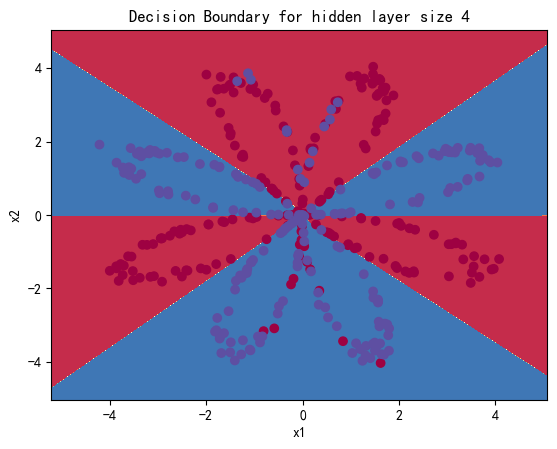

In [13]:
parameters = nn_model(X, Y, n_h=4, num_iterations=100000, print_cost=True)

# 绘制边界
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)

accuracy = (np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100
print('准确率: %.2f%%' % accuracy.item())

#### 更改隐藏层节点数量


准确率: 66.50%
准确率: 63.75%
准确率: 87.25%
准确率: 87.00%
准确率: 88.00%
准确率: 88.00%
准确率: 87.25%


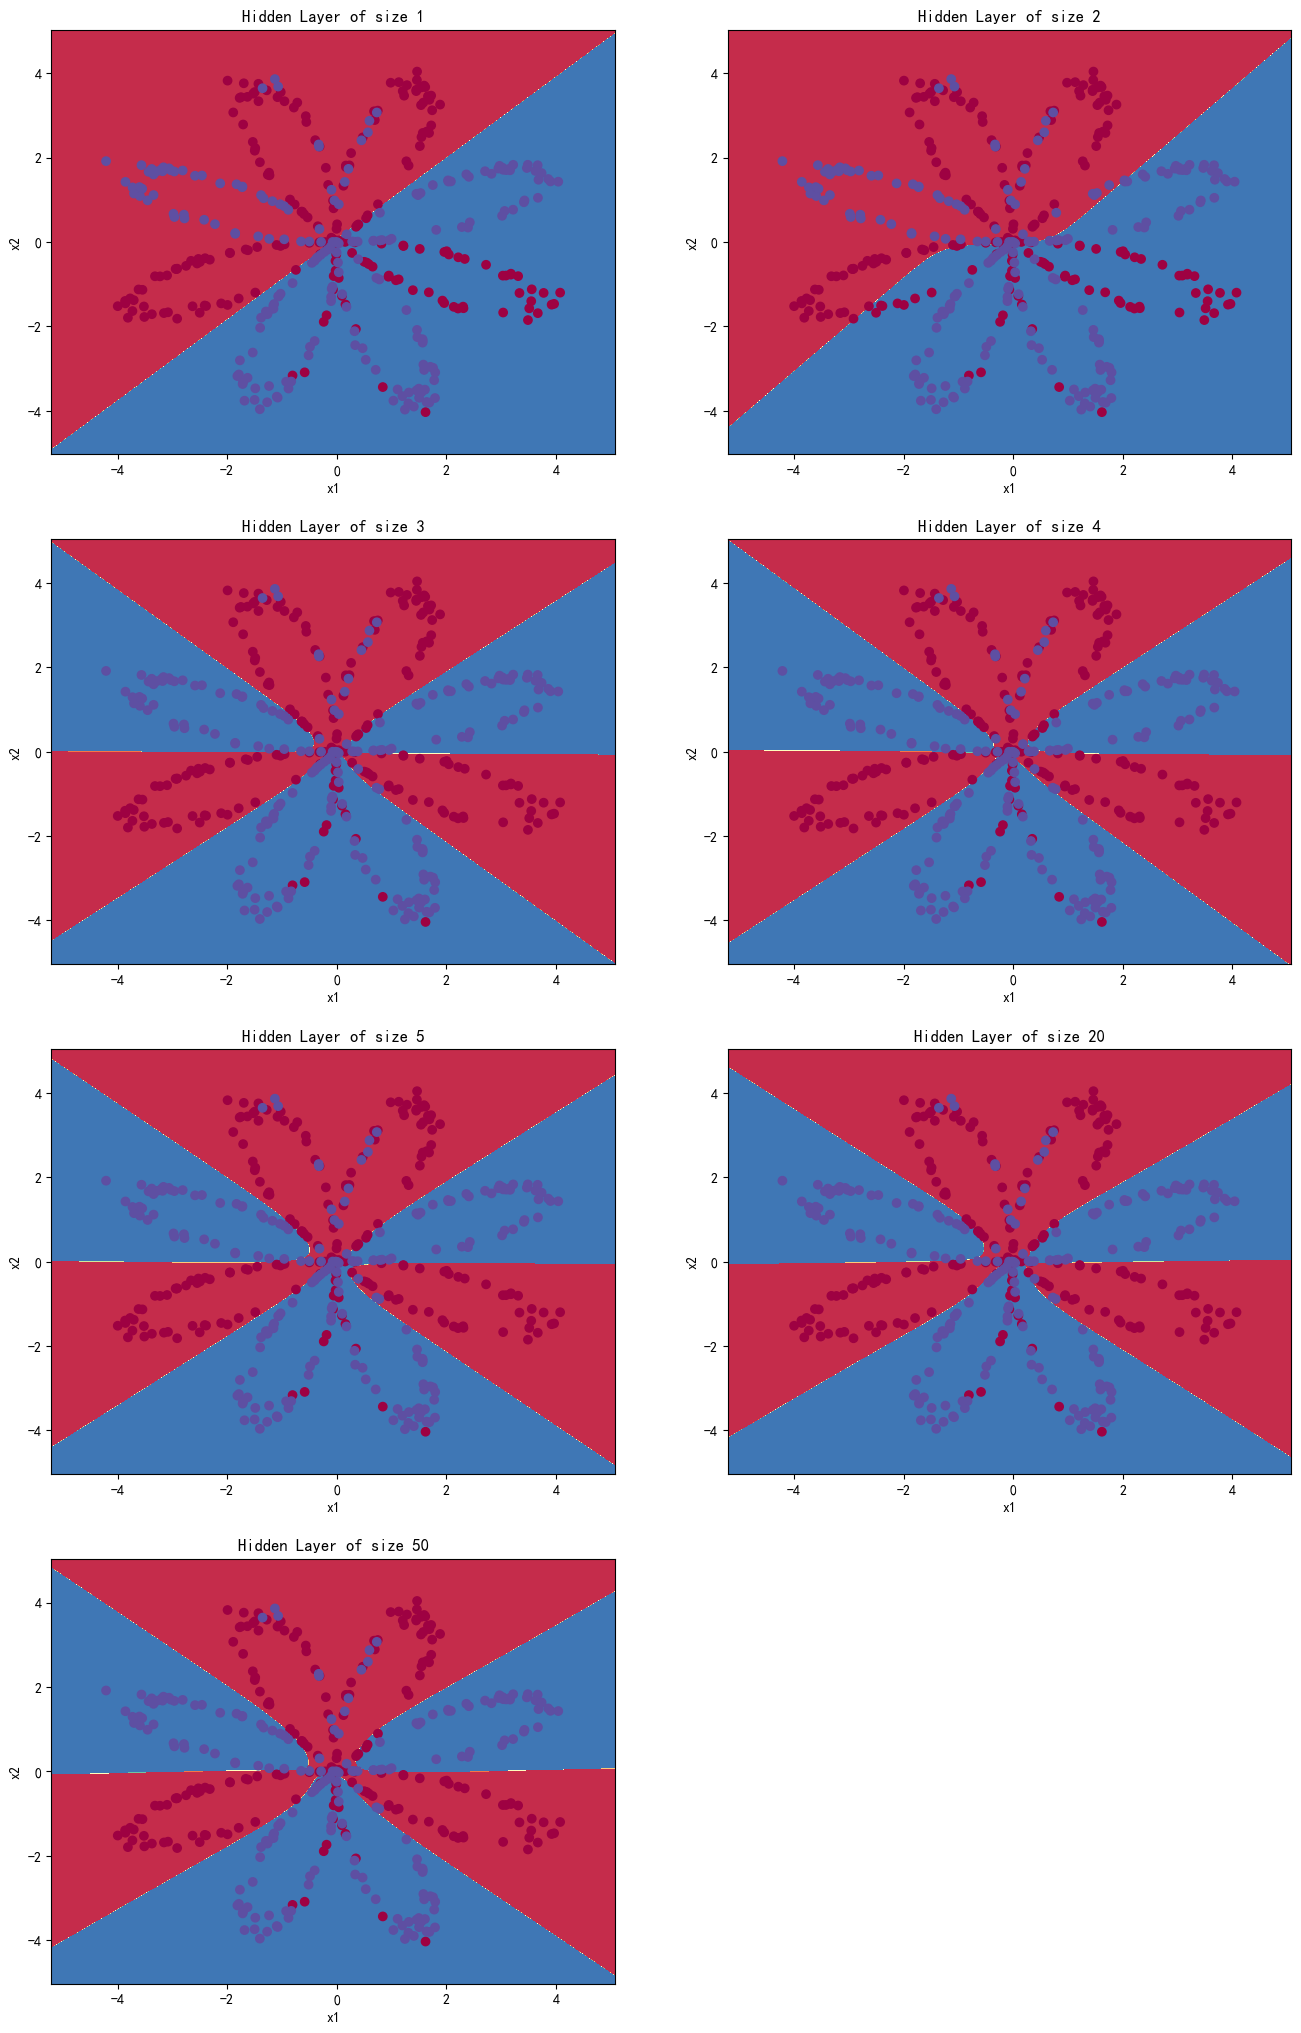

In [14]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i + 1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = (np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100
    print('准确率: %.2f%%' % accuracy.item())
